In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Text(0, 0.5, 'Count')

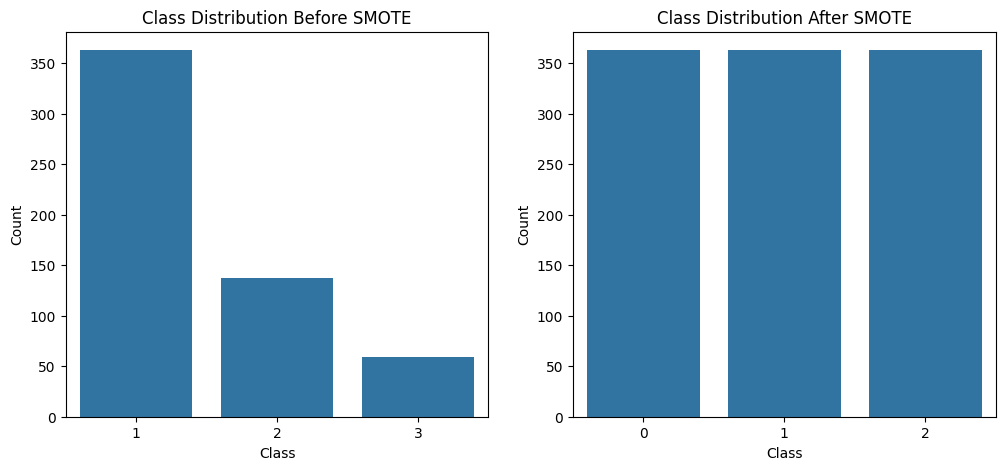

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score
import warnings

# Suppress Warnings
warnings.filterwarnings('ignore')

# Seed Initialization
np.random.seed(42)

# Load Data
file_path = '/content/drive/My Drive/Data_ADNIMerge_procssedNeuroImaging.csv'
data = pd.read_csv(file_path)

# Visualize Class Distribution Before SMOTE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='AD_LABEL', data=data)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')

# Data Preprocessing
data = data.drop(["RID"], axis=1)

# Separate Features and Target
X = data.drop("AD_LABEL", axis=1)
y = data["AD_LABEL"] - 1

# Apply SMOTE to both features and target
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Visualize Class Distribution After SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')


In [ ]:
data.shape

(559, 223)

In [ ]:
class ConfidenceSoftmax(tf.keras.layers.Layer):
    def __init__(self, temperature=1.5, **kwargs):
        super(ConfidenceSoftmax, self).__init__(**kwargs)
        self.temperature = temperature

    def call(self, inputs):
        scaled_inputs = inputs / self.temperature
        softmax = tf.nn.softmax(scaled_inputs)
        confidence = tf.reduce_max(softmax, axis=-1, keepdims=True)
        return tf.concat([softmax, confidence], axis=-1)

# Define Neural Network Model with Confidence Softmax Layer
def create_model_with_confidence(temperature=1.5):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(223, activation='relu', input_shape=(X_resampled.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3),
        ConfidenceSoftmax(temperature)  # Confidence softmax as a layer
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize Cross-Validation (Leave-One-Out)
loo = LeaveOneOut()

# Perform Cross-Validation
predictions = []
true_labels = []
confidences = []
accuracies = []

for train_index, test_index in loo.split(X_resampled):
    X_train_loo, X_test_loo = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train_loo, y_test_loo = y_resampled[train_index], y_resampled[test_index]

    model = create_model_with_confidence(temperature=1.0)  # Adjust temperature here
    model.fit(X_train_loo, y_train_loo, epochs=10, verbose=0)

    prediction_with_confidence = model.predict(X_test_loo)
    predicted_class = np.argmax(prediction_with_confidence[:, :-1], axis=-1)
    confidence = prediction_with_confidence[:, -1]  # Confidence score is the last element
    true_label = int(y_test_loo)
    accuracy = accuracy_score([true_label], [predicted_class])

    predictions.append(predicted_class)
    confidences.append(confidence)
    true_labels.append(true_label)
    accuracies.append(accuracy)

    print(f"Iteration {len(predictions)}: Predicted Class {predicted_class}, True Class {true_label}, Accuracy {accuracy:.4f}, Confidence {confidence[0]:.4f}")

1/1 [==============================] - 1s 517ms/step
Iteration 1: Predicted Class [1], True Class 0, Accuracy 0.0000, Confidence 0.7438
1/1 [==============================] - 0s 123ms/step
Iteration 2: Predicted Class [1], True Class 0, Accuracy 0.0000, Confidence 0.5273
1/1 [==============================] - 0s 66ms/step
Iteration 3: Predicted Class [0], True Class 1, Accuracy 0.0000, Confidence 0.4020
1/1 [==============================] - 0s 93ms/step
Iteration 4: Predicted Class [2], True Class 1, Accuracy 0.0000, Confidence 0.4654


1/1 [==============================] - 0s 155ms/step
Iteration 5: Predicted Class [1], True Class 1, Accuracy 1.0000, Confidence 0.8513


1/1 [==============================] - 0s 363ms/step
Iteration 6: Predicted Class [1], True Class 0, Accuracy 0.0000, Confidence 0.7564
1/1 [==============================] - 0s 69ms/step
Iteration 7: Predicted Class [2], True Class 2, Accuracy 1.0000, Confidence 0.9652
1/1 [==============================] - 0s 67ms/step
Iteration 8: Predicted Class [1], True Class 0, Accuracy 0.0000, Confidence 0.4346
1/1 [==============================] - 0s 64ms/step
Iteration 9: Predicted Class [1], True Class 1, Accuracy 1.0000, Confidence 0.6738
1/1 [==============================] - 0s 66ms/step
Iteration 10: Predicted Class [1], True Class 1, Accuracy 1.0000, Confidence 0.7175
1/1 [==============================] - 0s 73ms/step
Iteration 11: Predicted Class [1], True Class 1, Accuracy 1.0000, Confidence 0.4050
1/1 [==============================] - 0s 65ms/step
Iteration 12: Predicted Class [0], True Class 0, Accuracy 1.0000, Confidence 0.8963
1/1 [==============================] - 0s 66ms/step

In [ ]:
# Calculate Confidence for Each Class
confidence_values = np.zeros((3, 3))
for true_label, confidence in zip(true_labels, confidences):
    confidence_values[true_label] += confidence

# Overall Average Confidence Score
avg_confidence_overall = np.mean(confidences)
print(f"\nOverall Average Confidence Score: {avg_confidence_overall:.4f}")

# Normalize Confidence Values
row_sums = confidence_values.sum(axis=1)
confidence_values_normalized = confidence_values / row_sums[:, np.newaxis]

# Calculate TP, FP, TN, FN
conf_matrix = confusion_matrix(true_labels, predictions)
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Print TP, FP, TN, FN
print("\nTrue Positives (TP):", TP)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)
print("False Negatives (FN):", FN)

# Print Confusion Matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Calculate average accuracy and standard deviation
avg_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")

# Average Confidence of TP, FP, TN, FN
avg_confidence_TP = np.mean([conf for i, conf in enumerate(confidences) if i in TP])
avg_confidence_FP = np.mean([conf for i, conf in enumerate(confidences) if i in FP])
avg_confidence_TN = np.mean([conf for i, conf in enumerate(confidences) if i in TN])
avg_confidence_FN = np.mean([conf for i, conf in enumerate(confidences) if i in FN])

print("\nAverage Confidence of True Positives (TP):", avg_confidence_TP)
print("Average Confidence of False Positives (FP):", avg_confidence_FP)
print("Average Confidence of True Negatives (TN):", avg_confidence_TN)
print("Average Confidence of False Negatives (FN):", avg_confidence_FN)

# Standard deviation of confidence scores
std_confidence = np.std(confidences)
print(f"\nStandard Deviation of Confidence Scores: {std_confidence:.4f}")

# Calculate F1 Score
f1 = f1_score(true_labels, predictions, average='macro')
print(f"\nF1 Score: {f1:.4f}")

# Calculate Precision
precision = precision_score(true_labels, predictions, average='macro')
print(f"Precision: {precision:.4f}")

# Calculate Recall
recall = recall_score(true_labels, predictions, average='macro')
print(f"Recall: {recall:.4f}")



Overall Average Confidence Score: 0.7888

True Positives (TP): [290 277 339]
False Positives (FP): [54 89 40]
True Negatives (TN): [672 637 686]
False Negatives (FN): [73 86 24]

Confusion Matrix:
[[290  67   6]
 [ 52 277  34]
 [  2  22 339]]
Average Accuracy: 0.8320
Standard Deviation of Accuracy: 0.3739

Average Confidence of True Positives (TP): 0.94011134
Average Confidence of False Positives (FP): 0.66895586
Average Confidence of True Negatives (TN): 0.5368771
Average Confidence of False Negatives (FN): 0.77827674

Standard Deviation of Confidence Scores: 0.1678

F1 Score: 0.8314
Precision: 0.8314
Recall: 0.8320
